In [12]:
#!/usr/bin/env python3
import argparse
import lzma
import os
import pickle
import sys
from typing import Optional
import urllib.request
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

import numpy as np
import numpy.typing as npt

parser = argparse.ArgumentParser()
parser.add_argument("--predict", default=None, type=str)
parser.add_argument("--recodex", default=False, action="store_true")
parser.add_argument("--seed", default=42, type=int)
parser.add_argument("--model_path", default="rental_competition.model", type=str)

args = parser.parse_args([])

In [ ]:
    """Rental Dataset.

    The dataset instances consist of the following 12 features:
    - season (1: winter, 2: spring, 3: summer, 4: autumn)
    - year (0: 2011, 1: 2012)
    - month (1-12)
    - hour (0-23)
    - holiday (binary indicator)
    - day of week (0: Sun, 1: Mon, ..., 6: Sat)
    - working day (binary indicator; a day is neither weekend nor holiday)
    - weather (1: clear, 2: mist, 3: light rain, 4: heavy rain)
    - temperature (normalized so that -8 Celsius is 0 and 39 Celsius is 1)
    - feeling temperature (normalized so that -16 Celsius is 0 and 50 Celsius is 1)
    - relative humidity (0-1 range)
    - windspeed (normalized to 0-1 range)

    The target variable is the number of rented bikes in the given hour.
    """

In [13]:
class Dataset:                                     
    def __init__(self,
                 name="rental_competition.train.npz",
                 url="https://ufal.mff.cuni.cz/~courses/npfl129/2425/datasets/"):
        if not os.path.exists(name):
            print("Downloading dataset {}...".format(name), file=sys.stderr)
            urllib.request.urlretrieve(url + name, filename="{}.tmp".format(name))
            os.rename("{}.tmp".format(name), name)

        # Load the dataset and return the data and targets.
        dataset = np.load(name)
        for key, value in dataset.items():
            setattr(self, key, value)


In [14]:
def findBestAlpha(X_train, X_test, y_train, y_test) -> float:
    import sys
    lambdas = np.geomspace(0.01, 10, num=500)

    best_rmse = sys.maxsize
    best_lambda = 0
    for a in lambdas:
        model = sklearn.linear_model.SGDRegressor(
            penalty = 'l2', alpha = a, eta0=0.001, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r = float(np.sqrt(np.mean(abs(y_test - y_pred) ** 2)))
            
        if r < best_rmse:
            best_rmse = r
            best_lambda = a
    return best_lambda

In [ ]:
def findBestLRate(X_train, X_test, y_train, y_test, a) -> float:
    import sys
    best_rmse = sys.maxsize
    best_rate = 0
    rmse = sys.maxsize
    rate = 0

    low, high = 0, 1.0
    mean = (low + high) / 2

    for i in range(100):
        model_l = sklearn.linear_model.SGDRegressor(
            penalty = 'l2', alpha = a, eta0_l= (low + mean) / 2, max_iter=1000)
        model_l.fit(X_train, y_train)
        y_pred_l = model_l.predict(X_test)
        r_l = float(np.sqrt(np.mean(abs(y_test - y_pred_l) ** 2)))

        model_h = = sklearn.linear_model.SGDRegressor(
            penalty = 'l2', alpha = a, eta0_h= (high + mean) / 2, max_iter=1000)
        model_h.fit(X_train, y_train)
        y_pred_h = model_l.predict(X_test)
        
        r_h = float(np.sqrt(np.mean(abs(y_test - y_pred_l) ** 2)))

        if(r_l < r_h):
            high = mean
            rate = eta0_l
            rmse = r_l
        else:
            low = mean
            rate = eta0_h
            rmse = r_h
        mean = (low + high) / 2

        if(rmse < best_rmse):
            best_rmse = rmse
            best_rate = rate
        else:
            return best_rate
    

In [10]:
def preprocess(X_train, X_test):
    def is_integer_only(col : np.ndarray) -> bool:
        return np.all(col == np.round(col))
    d_size = X_train.shape[1]
    int_ind = [i for i in range(d_size) if is_integer_only(X_train[:, i])]
    rest_ind = [i for i in range(d_size) if i not in int_ind]
    preprocess = sklearn.compose.ColumnTransformer(
            [("ints", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore", sparse_output=False), int_ind),
            ("rests", sklearn.preprocessing.StandardScaler(), rest_ind)]
    )
    
    X_train_trans = preprocess.fit_transform(X_train)
    X_test_trans = preprocess.transform(X_test)
    
    poly = sklearn.preprocessing.PolynomialFeatures(2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_trans)
    X_test_poly = poly.transform(X_test_trans)
    return X_train_poly, X_test_poly

In [ ]:
if args.predict is None:
    # We are training a model.
    # TODO: Train a model on the given dataset and store it in `model`.
    np.random.seed(args.seed)
    train = Dataset()
    X = train.data
    y = train.target
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                            X, y, test_size=100, random_state=args.seed)
    (X_train_p, X_test_p) = preprocess(X_train, X_test)
    a = findBestAlpha(X_train_p, X_test_p, y_train, y_test)
    l_rate = findBestLRate(X_train_p, X_test_p, y_train, y_test, alpha)
    
    model = sklearn.linear_model.SGDRegressor(
            penalty = 'l2', alpha = a, eta0=l_rate, max_iter=1000)

    # Serialize the model.
    with lzma.open(args.model_path, "wb") as model_file:
        pickle.dump(model, model_file)

In [52]:
if args.predict is not None:
    # Use the model and return test set predictions, either as a Python list or a NumPy array.
    test = Dataset(args.predict)

    with lzma.open(args.model_path, "rb") as model_file:
        model = pickle.load(model_file)

    # TODO: Generate `predictions` with the test set predictions.
    predictions = X @ model

    predictions[:5]

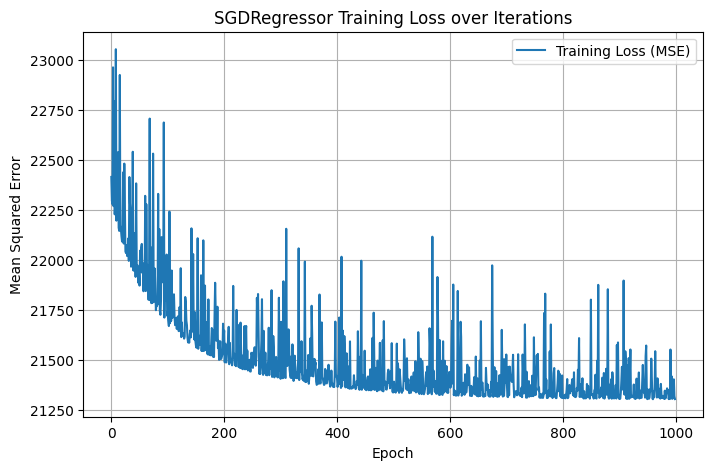

In [22]:
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
model = sklearn.linear_model.SGDRegressor(
            penalty = 'l2', alpha = 0.1, eta0=0.001, max_iter=5000)
np.random.seed(args.seed)
train = Dataset()
X = train.data
y = train.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                        X, y, test_size=100, random_state=args.seed)

model.fit(X_train, y_train)
losses = []
n_epochs = 1000

for epoch in range(n_epochs):
    model.partial_fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse = np.mean((y_train - y_pred) ** 2)
    losses.append(mse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss (MSE)", color="tab:blue")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("SGDRegressor Training Loss over Iterations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if __name__ == "__main__":
    
    main(main_args) 